# 📌 Label Data : Localization ➡️ Segmentation
* Label Data를 아래 이미지와 같이 변경하게 되면 Segmentation을 위한 데이터를 완성
* FracAtlas 데이터의 골절 라벨링된 부분을 보면 골절 부분을 정확히 라벨링 한 것이 아니라 그 주변을 라벨링 해 놓았기에 이와 같이 polygon 안 쪽을 채운 라벨 데이터를 만들게 되었을 때 Bounding Box 같은 정보보다 골절 부분을 더 세밀하게 레이블 하게 되어 골절을 찾는 다는 목적에 더 부합하다고 생각하여 이렇게 라벨링을 진행하였습니다.

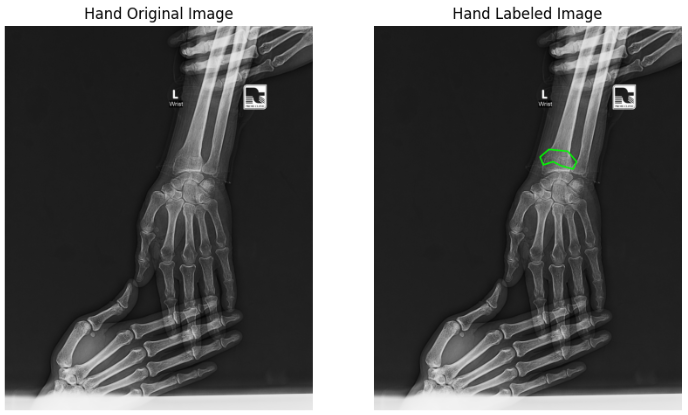
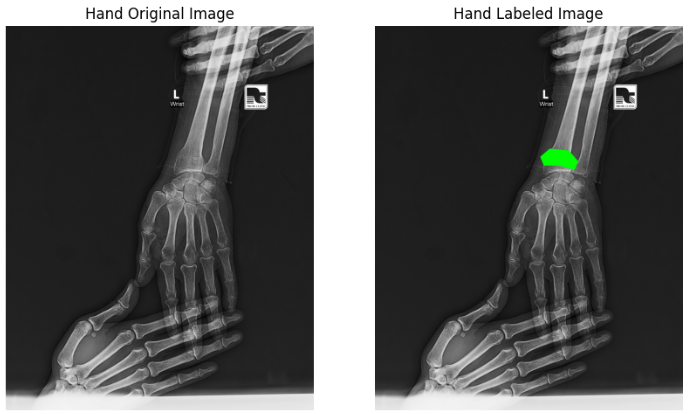



# 0. 라이브러리 호출

In [1]:
import os
import cv2
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# 1. 라벨링에 필요한 Function 구현

### 1-1. 전체 이미지 파일명을 갖는 List 생성

In [2]:
def get_image_names(image_folder):

    file_names = []

    for filename in os.listdir(image_folder):
        if filename.endswith('.jpg'):
            file_names.append(filename)

    file_names.sort()
    
    return file_names

### 1-2. VGG_fracture_mask.json 파일을 json_data 변수로 읽어옴.

In [3]:
def get_mask_in_json(json_folder):
    
    with open(json_folder, "r") as f:
        json_data = json.load(f)

    return json_data

### 1-3. get_polygon_coordinates
* VGG_fracture_mask.json 파일에서 polygon 좌표 가져오는 코드

In [4]:
def get_polygon_coordinates(image_name, json_data):
    all_points_x_list = []
    all_points_y_list = []
    all_points = []

    for region in json_data[image_name]['regions'].values():
        all_points_x_list.append(region['shape_attributes']['all_points_x'])
        all_points_y_list.append(region['shape_attributes']['all_points_y'])

    for i in range(len(all_points_x_list)):
        all_points.append(np.array(list(zip(all_points_x_list[i], all_points_y_list[i])), np.int32))

    return all_points

### 1-4. fractured_fill_polygon 함수
* polygon 좌표를 활용해서 한 이미지에 대해 polygon 내부를 채워준다.
* np.zeros에 fillpoly 함수를 통해 만든 좌표를 찍어준다.
* 그렇게 하여 각 이미지에 대한 mask 데이터를 얻는다.

In [5]:
def fractured_fill_polygon(image_name, polygon_coordinates):

    # mask의 사이즈 확인
    image_path = "./data/images/Fractured/" + image_name
    
    with Image.open(image_path) as img:
        w, h = img.size
    
    # 0으로 채워진 mask 생성
    mask = np.zeros((h, w), dtype=np.uint8)
    
    # polygon 좌표 안쪽을 255로 채운 mask 얻음.
    cv2.fillPoly(mask, polygon_coordinates, color=255)
    
    return mask

### 1-5. non_fractured_zeros 함수
* 정상 데이터는 라벨이 없고 각 이미지의 사이즈에 맞는 zeros를 생성하기 위한 코드

In [6]:
def non_fractured_zeros(image_name):

    image_path = "./data/images/Non_fractured/" + image_name
    
    with Image.open(image_path) as img:
        w, h = img.size

    mask = np.zeros((h, w), dtype=np.uint8)

    return mask

# 2. main code

### 2-1. Fracture, Non_fracture data의 라벨을 갖는 mask를 생성 완료

In [7]:
non_fractured_file_names = get_image_names('./data/images/Non_fractured')
fractured_file_names = get_image_names('./data/images/Fractured')
json_data = get_mask_in_json("./data/VGG_fracture_masks.json")

non_fractured_mask_list = []
fractured_mask_list = []

for i in non_fractured_file_names:
    mask = non_fractured_zeros(i)
    non_fractured_mask_list.append(mask)
    
for i in fractured_file_names:
    mask = fractured_fill_polygon(i, get_polygon_coordinates(i, json_data))
    fractured_mask_list.append(mask)

### 2-2. fractured_mask 데이터를 npy 저장

In [37]:
mask_data_array = np.array(fractured_mask_list, dtype=object)
np.save('Fractured_mask', mask_data_array)

Fractured_mask = np.load("./Fractured_mask.npy", allow_pickle=True)

Fractured_mask.shape

(717,)

### 2-3. fractured_mask 데이터를 (240, 240)으로 resize해서 npy로 저장

In [39]:
mask_data_array = np.array(fractured_mask_list, dtype=object)

resized_masks = np.array([cv2.resize(mask, (240, 240)) for mask in mask_data_array])
np.save('Fractured_mask_240', resized_masks)

Fractured_mask_240 = np.load("./Fractured_mask_240.npy")

Fractured_mask_240.shape

(717, 240, 240)

# 3. 데이터 확인

### 3-1. jpg인 Fracture data를 npy로 변경
* plt.imshow로 시각화 하기 위해서

In [42]:
import os
import cv2
import numpy as np

image_folder = './data/images/Fractured'
output_file = 'Fractured'

image_data = []

# 파일 목록을 오름차순으로 정렬하여 가져오기
for filename in sorted(os.listdir(image_folder)):
    if filename.endswith('.jpg'):
        img_path = os.path.join(image_folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            image_data.append(img)

# 리스트를 NumPy 배열로 변환하여 저장
image_data_array = np.array(image_data, dtype=object)
np.save(output_file, image_data_array)  # npy 파일로 저장

# npy 데이터 load 후 shape 출력
Fractured = np.load("./Fractured.npy", allow_pickle=True)

Fractured.shape

(717,)

### 3-2. Fractured data를 (240, 240)으로 resize 해서 npy로 변경

In [41]:
import os
import cv2
import numpy as np

image_folder = './data/images/Fractured'
output_file = 'Fractured_240'

image_data = []

# 파일 목록을 오름차순으로 정렬하여 가져오기
for filename in sorted(os.listdir(image_folder)):
    if filename.endswith('.jpg'):
        img_path = os.path.join(image_folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_resized = cv2.resize(img, (240, 240))
        image_data.append(img_resized)
        
# 리스트를 NumPy 배열로 변환하여 저장
image_data_array = np.array(image_data)
np.save(output_file, image_data_array)  # npy 파일로 저장

# npy 데이터 load 후 shape 출력
Fractured_240 = np.load("./Fractured_240.npy")

Fractured_240.shape

(717, 240, 240)

### 3-3. image, label, overlap 시각화
* 원본 이미지에 위에서 만든 라벨을 겹친 이미지를 시각화

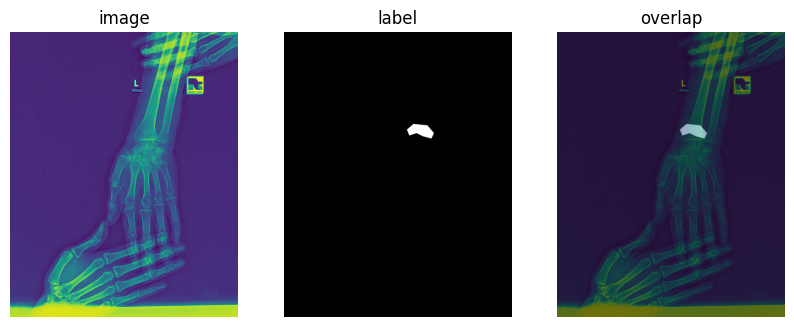

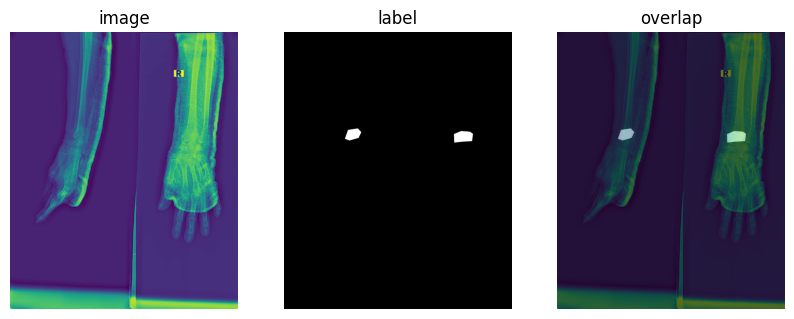

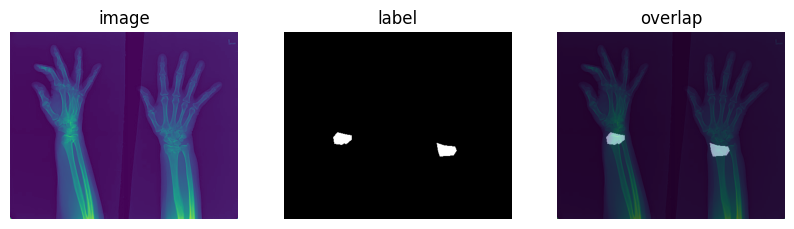

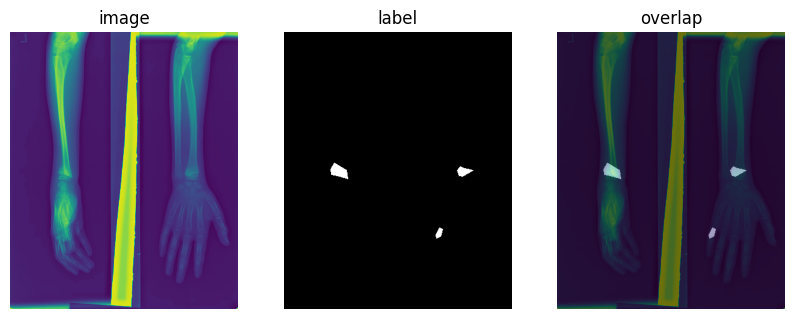

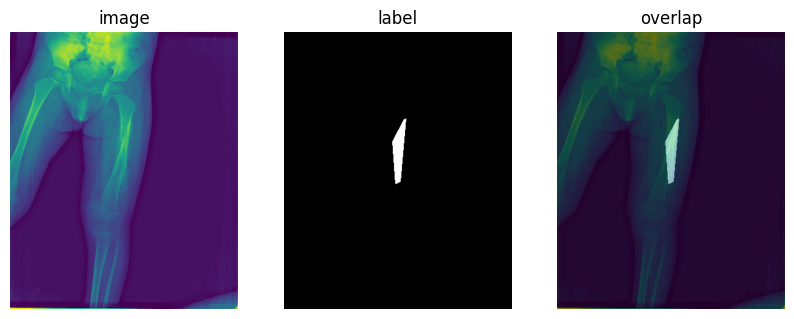

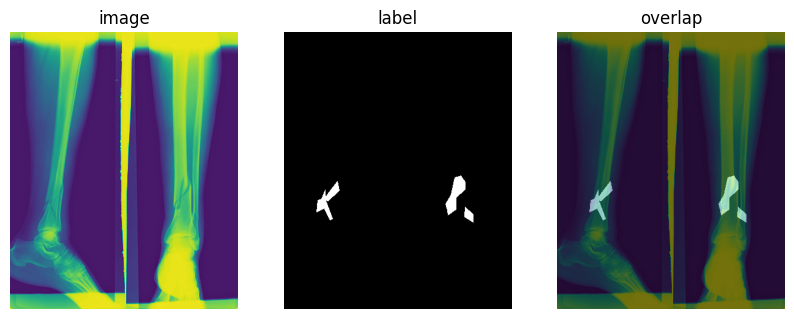

In [9]:
import matplotlib.pyplot as plt

num_list = [0, 19, 20, 21, 391, 424]

for num in num_list:
    plt.figure(figsize=(10, 5))
    
    # 원본 이미지
    plt.subplot(131)
    plt.imshow(Fractured[num])
    plt.title("image")
    plt.axis("off")
    
    # 마스크 이미지
    plt.subplot(132)
    plt.imshow(fractured_mask_list[num], cmap='gray')
    plt.title("label")
    plt.axis("off")
    
    # 겹쳐보기 (overlap)
    plt.subplot(133)
    plt.imshow(fractured_mask_list[num], cmap='gray')
    plt.title("overlap")
    plt.axis("off")
    plt.imshow(Fractured[num], alpha=0.5)
    
    plt.show()
